In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchtext.data
import torchtext.datasets

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device = cuda


# Load models and Data: 

In [8]:
model_gru = torch.load("./models/sentimentGRU_final.pt")
model_attention = torch.load("./models/selfAttention1L_final.pt")

In [9]:
review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

# This Field object converts the text labels into numeric values (0,1,2)
label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

# Load SST, tokenize the samples and labels
# ds_X are Dataset objects which will use the parsers to return tensors
ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(review_parser, label_parser)


dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=64, shuffle=False, device=device)

review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

# Data Visualization

Get predictions from model:

In [10]:
def get_preds_and_labels(model, dl, device):
    model.eval()
    predictions = torch.tensor([]).to(device)
    gt_labels = torch.tensor([]).to(device)

    for i,batch in enumerate(dl):
        X, y = batch
        
        curr_preds, _ = model(X)
        
        predictions = torch.cat((predictions, curr_preds), dim=0)
        gt_labels = torch.cat((gt_labels, y), dim=0)
    model.train()
    
    return predictions , gt_labels

baseline_preds, baseline_gt = get_preds_and_labels(model_gru, dl_test, device)
attention_preds, attention_gt = get_preds_and_labels(model_attention, dl_test, device)

print("Baseline model accuracy:", torch.sum(baseline_preds == baseline_gt).item()/baseline_preds.shape[0])
print("Self-Attention model accuracy:", torch.sum(attention_preds == attention_gt).item()/attention_preds.shape[0] )

Baseline model accuracy: 0.6271493212669683
Self-Attention model accuracy: 0.6606334841628959


# Confusion Matrices

Text(0.5, 1.0, 'Self-Attention Confusion Matrix\n')

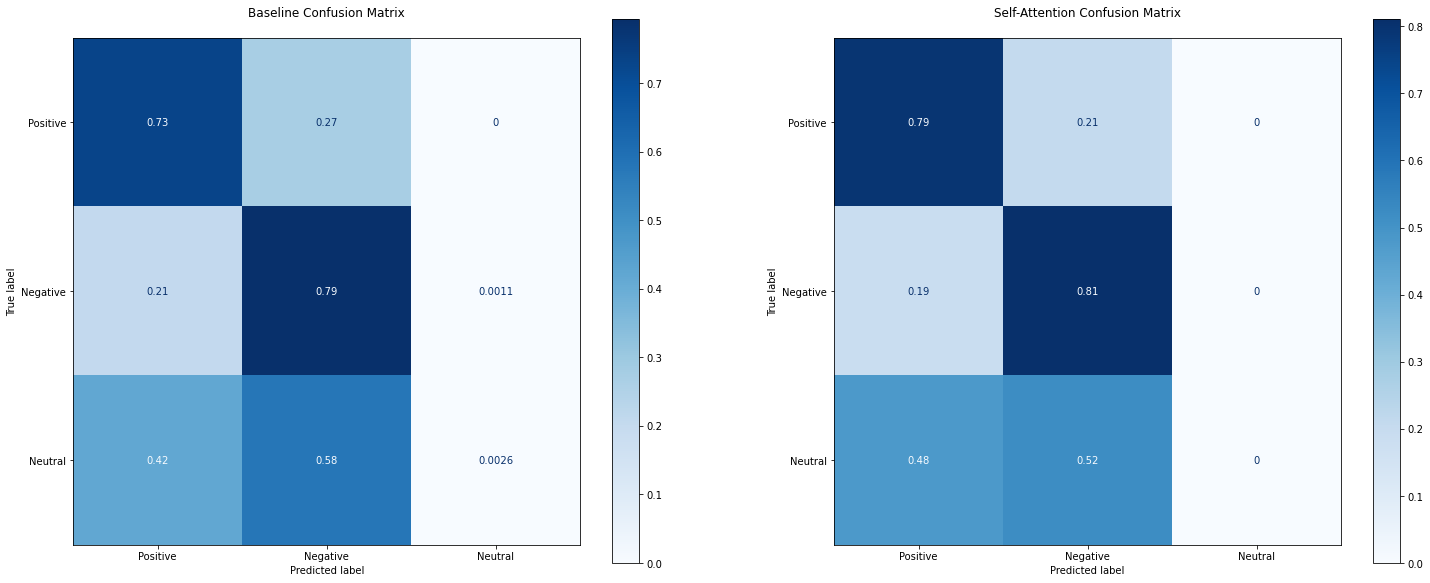

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
class_names = ['Positive','Negative','Neutral']

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1 , figsize=(25, 10))
disp = plot_confusion_matrix(IC, baseline_preds.cpu(), baseline_gt.cpu(), display_labels=class_names,
                             normalize='true', cmap=plt.cm.Blues, ax=ax1);
disp.ax_.set_title('Baseline Confusion Matrix\n')

disp = plot_confusion_matrix(IC, attention_preds.cpu(), attention_gt.cpu() ,display_labels=class_names,
                             normalize='true', cmap=plt.cm.Blues, ax=ax2);
disp.ax_.set_title('Self-Attention Confusion Matrix\n')

# Attention Visualization 

In [12]:
def VisAttention(input_sentence, attentions):
     # Set up figure with colorbar
    fig = plt.figure(figsize=(25, 10))
    ax = fig.add_subplot()
    cax = ax.matshow(attentions.numpy(), cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence , rotation=90 , Fontsize=12)
    ax.set_yticklabels([''] + input_sentence, Fontsize=12)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.tight_layout()
    plt.show()

In [ ]:
v = review_parser.vocab

it = iter(dl_test)

for _ in range(10):
    batch = next(it)
    review_str_list = [v.itos[token] for token in batch.text[:,42]]
    review_text = ' '.join(review_str_list)
    print(review_text)

    model_attention.eval()
    _, _, weights_out = model_attention(batch.text, get_attention_weights=True)
    model_attention.train()

    VisAttention(review_str_list, weights_out[0][1].cpu().detach())

In [ ]:
print(dl_test.data()[500].text)